In [1]:
import numpy as np
import pandas as pd
import pathlib
import os
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_pinball_loss,
)

from utils_experiment import (
    load_data,
    get_model_list,
    plot_forecasts_analysis,
    rmse,
    pinball_loss,
    average_pinball_loss,
    plot_quantile_forecast
)

In [2]:




# for EXP_BASE in EXP_BASE_LIST:
#     EXP_MODEL_LIST = get_model_list(EXP_BASE)

#     for model_type in EXP_MODEL_LIST:
#         EXPERIMENT_NAME = f"{EXP_BASE}_{model_type}"
#         experiments.append(EXPERIMENT_NAME)

# experiments

Above is a list of all of the possible models, if you would like to limit which models are included:

In [3]:
exp_test_description = "LLMP_Experiments_v2"
directory = f"/h/kupfersk/cfpr_2025/generate_forecasts/output/"

report_sim_dates = open("experiment_cutoff_dates.txt", 'r').read().split()
# report_sim_dates = report_sim_dates[:-1]

# report_sim_dates= [report_sim_dates[-1]]

target_categories = [
    'Bakery and cereal products (excluding baby food)',
#      'Dairy products and eggs',
#      'Fish, seafood and other marine products',
#      'Food purchased from restaurants',
#      'Food',
#      'Fruit, fruit preparations and nuts',
     'Meat',
#      'Other food products and non-alcoholic beverages',
     'Vegetables and vegetable preparations'
]


target_categories = [f"food_cpi: {col}" for col in target_categories]

start_years = [1986]
random_seed = 42

print("Target Categories:\n" + '\n'.join(target_categories))
print("Report Simulation Dates:\n" + '\n'.join(report_sim_dates))



file_path = "../data/processed_data/all_data_processed.csv"
all_data, foodprice_df, target_categories, all_covariates = load_data(target_categories, file_path)

Target Categories:
food_cpi: Bakery and cereal products (excluding baby food)
food_cpi: Meat
food_cpi: Vegetables and vegetable preparations
Report Simulation Dates:
2018-07-01
2019-07-01
2020-07-01
2021-07-01
2022-07-01
2023-07-01


In [4]:
EXP_BASE_LIST = ["ag_local", "ag_global_cpi", "ag_global_with_covariates"]

ignore_list = [".csv",
               "ipynb",
#                 "llama",
#                 "gemini",
#                 "claude",
#                 "gpt",
               "Mixtral"
               '5th',
               "restaurants",
               "DeepARModel_exp",
               "ChronosModel_exp",
               "PatchTSTModel_exp",
               "DLinearModel_exp",
               "exp7",
               "exp8",
               "corr",
               "economic",
               "code"
#                "report",

               

               
               
]

experiments = []
# for experiment_name in os.listdir(f"{directory}{exp_test_description}"):
#     if 'ipynb' not in experiment_name:
#         if '.csv' not in experiment_name:
#             if "ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp" not in experiment_name:
#                 if "llama" not in experiment_name:
#                     if "gemini" not in experiment_name:
#                         if "claude" not in experiment_name:
#                             if "gpt" not in experiment_name:



#                 experiments.append(experiment_name)

for experiment_name in os.listdir(f"{directory}{exp_test_description}"):
    if all(keyword not in experiment_name for keyword in ignore_list):
        experiments.append(experiment_name)


        # # Read the file and store the content in a list
        # llm_directory = '/h/kupfersk/cfpr_llm/Results_percentiles/Raw_data/'

        # with open((llm_directory + 'llm_models.txt'), 'r') as file:
        #     # Read all lines and strip any extra whitespace/newline characters
        #     loaded_list = [line.strip() for line in file]


        # experiments = experiments + loaded_list
experiments

['gemini-1.5-pro_future_exo_english_desc_True_75_report_pdf_median',
 'llama-3.1-70B_future_exo_english_desc_False_75_item',
 'claude-3-5-sonnet-20241022_future_exo_english_desc_True_75_report_text_median',
 'gemini-1.5-pro_future_exo_english_desc_True_75_report_False_median',
 'llama-3.1-70B_exo_english_desc_False_75_item',
 'gpt-4o_future_exo_english_desc_True_75_report_False_median',
 'claude-3-5-sonnet-20241022_future_exo_english_desc_True_75_report_pdf_median',
 'llama-3.1-70B_price_english_desc_False_75_item',
 'claude-3-5-sonnet-20241022_future_exo_english_desc_True_75_report_False_median',
 'gpt-4o_future_exo_english_desc_True_75_report_text_median',
 'gemini-1.5-pro_future_exo_english_desc_True_75_report_text_median',
 'llama-3.1-70B_future_english_desc_False_75_item']

## Evaluation Metrics


In [5]:
point_metrics = {
    "r2_score": r2_score,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error,
    "mse": mean_squared_error,
    "rmse": rmse,
}

In [6]:
experiments[1]

'llama-3.1-70B_future_exo_english_desc_False_75_item'

In [7]:
import json


def compute_all_scores(report_sim_dates, study_metric="mape"):
    global forecast_df
    global actual_df
    global predicted_categories
    
    results = []
    
        
    # Load the dictionary from the JSON file
    with open('target_category_dict_filt.json', 'r') as json_file:
        target_category_dict = json.load(json_file)
        
    for start_year in start_years:



        for EXPERIMENT_NAME in experiments:
            predicted_categories = []
            
            print(EXPERIMENT_NAME)
            if 'ag' in EXPERIMENT_NAME :
                if 'exp' in EXPERIMENT_NAME: 
                    general_experiment = f"exp{EXPERIMENT_NAME.split('_exp')[-1]}"
                    predicted_categories_in = target_category_dict[general_experiment]
                    
                    # Drop items containing the word 'restaurant' or exactly 'food_cpi: Food'
                    predicted_categories = [item for item in predicted_categories_in if 'restaurant' not in item.lower() and item != 'food_cpi: Food']
                else:
                    predicted_categories = target_categories
                
#             else:
#                 predicted_categories = [
#                                         'food_cpi: Bakery and cereal products (excluding baby food)',
#                                          'food_cpi: Meat',
#                                          'food_cpi: Vegetables and vegetable preparations'
#                                     ]

            predicted_categories = target_categories

            for category in predicted_categories:
                if "restaurant" in category:
                    continue 
                    
                scores = []

                for cutoff_date in report_sim_dates:

                    forecast_csv_path = f"./output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
                    forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
                    forecast_df.index = pd.to_datetime(forecast_df.index)

                    actual_df = foodprice_df[category].loc[
                        [
                            date
                            for date in forecast_df.index
                            if date in foodprice_df.index
                        ]
                    ]
                    
                    if report_sim_dates[-1] == cutoff_date:
                        forecast_df = forecast_df.iloc[:-1]
                        actual_df = actual_df.iloc[:-1]


                    if study_metric in point_metrics:
                        median_col = "q_0.5"
                        y_pred = forecast_df[median_col]
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
                        )

                    elif study_metric == "pinball_loss":
                        y_pred = forecast_df
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            average_pinball_loss(
                                y_true=y_true,
                                y_pred_quantiles=y_pred,
                                quantiles=[
                                    0.01,
                                    0.05,
                                    0.1,
                                    0.25,
                                    0.75,
                                    0.9,
                                    0.95,
                                    0.99,
                                ],
                            )
                        )

                mean_score = np.mean(scores)
                std_score = np.std(scores)

                results.append(
                    {   "year": start_year,
                        "experiment": EXPERIMENT_NAME,
                        "category": category,
                        "mean_score": mean_score,
                        "std_score": std_score,
                        "scores": scores
                    }
                )

    return pd.DataFrame(results)



In [8]:
with open('target_category_dict_filt.json', 'r') as json_file:
    target_category_dict = json.load(json_file)
    
target_category_dict

{'exp5_geopolitical_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_manufacturing_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_climate_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi

In [9]:
## For classical model experiments 

mape_df = compute_all_scores(report_sim_dates, "mape")
mape_df

mape_df['path']= "f'./output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_42/{cutoff_date}/forecasts/{category}.csv'"

mape_df

gemini-1.5-pro_future_exo_english_desc_True_75_report_pdf_median
llama-3.1-70B_future_exo_english_desc_False_75_item
claude-3-5-sonnet-20241022_future_exo_english_desc_True_75_report_text_median
gemini-1.5-pro_future_exo_english_desc_True_75_report_False_median
llama-3.1-70B_exo_english_desc_False_75_item
gpt-4o_future_exo_english_desc_True_75_report_False_median
claude-3-5-sonnet-20241022_future_exo_english_desc_True_75_report_pdf_median
llama-3.1-70B_price_english_desc_False_75_item
claude-3-5-sonnet-20241022_future_exo_english_desc_True_75_report_False_median
gpt-4o_future_exo_english_desc_True_75_report_text_median
gemini-1.5-pro_future_exo_english_desc_True_75_report_text_median
llama-3.1-70B_future_english_desc_False_75_item


,year,experiment,category,mean_score,std_score,scores,path
0,1986,gemini-1.5-pro_future_exo_english_desc_True_75...,food_cpi: Bakery and cereal products (excludin...,0.047753,0.037556,"[0.017303252401060804, 0.021151181315439006, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...
1,1986,gemini-1.5-pro_future_exo_english_desc_True_75...,food_cpi: Meat,0.067951,0.030666,"[0.02706205493431495, 0.06858355794331288, 0.1...",f'./output/{exp_test_description}/{EXPERIMENT_...
2,1986,gemini-1.5-pro_future_exo_english_desc_True_75...,food_cpi: Vegetables and vegetable preparations,0.091656,0.038187,"[0.10581834860612284, 0.09035158088704237, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...
3,1986,llama-3.1-70B_future_exo_english_desc_False_75...,food_cpi: Bakery and cereal products (excludin...,0.031621,0.016986,"[0.013699214035841718, 0.019993387391535573, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...
4,1986,llama-3.1-70B_future_exo_english_desc_False_75...,food_cpi: Meat,0.023873,0.022388,"[0.02168206136633037, 0.0174837298865897, 0.07...",f'./output/{exp_test_description}/{EXPERIMENT_...
5,1986,llama-3.1-70B_future_exo_english_desc_False_75...,food_cpi: Vegetables and vegetable preparations,0.041665,0.027394,"[0.09486561768609886, 0.04909484233320956, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...
6,1986,claude-3-5-sonnet-20241022_future_exo_english_...,food_cpi: Bakery and cereal products (excludin...,0.039103,0.026015,"[0.01575671247572645, 0.01694520883856622, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...
7,1986,claude-3-5-sonnet-20241022_future_exo_english_...,food_cpi: Meat,0.037355,0.016815,"[0.03189072787893605, 0.06280923494002907, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...
8,1986,claude-3-5-sonnet-20241022_future_exo_english_...,food_cpi: Vegetables and vegetable preparations,0.071411,0.020046,"[0.09134306444023095, 0.052827535707430415, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...
9,1986,gemini-1.5-pro_future_exo_english_desc_True_75...,food_cpi: Bakery and cereal products (excludin...,0.058794,0.054551,"[0.016739661542927282, 0.024869351556058385, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...


In [10]:
# # Function to convert timestamp and set index
# def process_dataframe(df, path):
#     df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
#     df.set_index('Unnamed: 0', inplace=True)
#     return df

# # Define the file paths for each category
# file_paths = {
#     'meat': '../../cfpr_llm/Results_Oct9/combined_meat.csv',
#     'bakery': '../../cfpr_llm/Results_Oct9/combined_bakery.csv',
#     'vegetables': '../../cfpr_llm/Results_Oct9/combined_vegetables.csv'
# }

# # Load the data into separate DataFrames for each category
# meat_df = pd.read_csv(file_paths['meat'])
# bakery_df = pd.read_csv(file_paths['bakery'])
# vegetables_df = pd.read_csv(file_paths['vegetables'])


# # Apply the pre-processing to each category
# meat_df = process_dataframe(meat_df, file_paths['meat'])
# bakery_df = process_dataframe(bakery_df, file_paths['bakery'])
# vegetables_df = process_dataframe(vegetables_df, file_paths['vegetables'])


# #Calculate the mean absolute percent error 
# mape_meat = compute_llmp_scores(meat_df, 'food_cpi: Meat', "mape")
# mape_meat['path']= file_paths['meat']

# mape_bakery = compute_llmp_scores(bakery_df, 'food_cpi: Bakery and cereal products (excluding baby food)', "mape")
# mape_bakery['path']= file_paths['bakery']

# mape_vegetables = compute_llmp_scores(vegetables_df, 'food_cpi: Vegetables and vegetable preparations', "mape")
# mape_vegetables['path']= file_paths['vegetables']


# combine_llmp_mape = pd.concat([mape_meat, mape_bakery, mape_vegetables])
# combine_llmp_mape = combine_llmp_mape.reset_index().drop(columns='index')



In [11]:
# all_save_path = []

# # Iterate over each row in the combine_llmp_mape DataFrame
# for index, row in combine_llmp_mape.iterrows():
#     # Extract necessary information from the row
#     input_path = row['path']
#     experiment = row['experiment']
#     category = row['category']
#     category = row['category']

    
#     # Load the experiment data from the CSV
#     experiment_df = pd.read_csv(input_path)
    
#     # Create a placeholder DataFrame with q0.05, q0.5, q0.95 all set to the same values
#     output_df = pd.DataFrame({
#         'timestamp': pd.to_datetime(experiment_df['Unnamed: 0'].values).strftime('%Y-%m-%d'),
#         f"q_0.05": experiment_df[experiment].values,
#         f"q_0.95": experiment_df[experiment].values,
#         f"q_0.5": experiment_df[experiment].values,
#     })
    
        
#     # Define the save path using the extracted information
#     save_path = f'./output/LLMP_comparison/{experiment}/random_seed_42/{report_sim_dates[0]}/forecasts/'
    
#     # Create the necessary directory if it doesn't exist
#     os.makedirs(save_path, exist_ok=True)
    
#     # Save the output DataFrame to a CSV file
#     output_df.to_csv(os.path.join(save_path, f'{category}.csv'), index=False)
#     all_save_path.append(os.path.join(save_path, f'{category}.csv'))
    
# combine_llmp_mape['path']=all_save_path
    


In [12]:
# combine_llmp_mape.loc[combine_llmp_mape['category']=='food_cpi: Meat'].sort_values('mean_score')
# combine_llmp_mape.path.values

In [13]:
# pivoted_df = mape_df.pivot_table(
#     index=['year', 'experiment'],  # Keep year and experiment as the index
#     columns='category',            # Pivot based on the 'category' column
#     values='mean_score',           # Values to fill the pivot table (e.g., 'mean_score')
#     aggfunc='mean'                 # Aggregation function (mean in this case)
# ).reset_index()

# # Rename the columns (optional, to flatten the multi-level columns)
# pivoted_df.columns.name = None
# pivoted_df['overall'] = pivoted_df[mape_df.category.unique()].mean(axis=1)
# pivoted_df = pivoted_df.sort_values(by='overall')
# pivoted_df.to_csv('../../cfpr_llm/Results_Oct25/overall_results.csv')
# pivoted_df['experiment'].iloc[5]

In [14]:
overall_mape = mape_df 

In [15]:
best_results_year = []

for category in target_categories:
    # Filter rows for the current category
    category_rows = overall_mape.loc[overall_mape.category == category]
    
    # Get the top 5 experiments with the lowest mean_score
    top_rows = category_rows.nsmallest(15, "mean_score")
    
    # Append the results to the list
    for _, row in top_rows.iterrows():
        best_results_year.append(
            {
                "category": category,
                "top_experiment": row["experiment"],
                "mean_score": row["mean_score"],
                "path":row["path"],
                "scores":row["scores"]

            }
        )

best_results_year_df = pd.DataFrame(best_results_year)
best_results_year_df.to_csv(
    f"./output/{exp_test_description}/best_results_single_models.csv", index=False
)
best_results_year_df


,category,top_experiment,mean_score,path,scores
0,food_cpi: Bakery and cereal products (excludin...,llama-3.1-70B_future_english_desc_False_75_item,0.026262,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.013710346907131918, 0.01252322956640991, 0...."
1,food_cpi: Bakery and cereal products (excludin...,llama-3.1-70B_price_english_desc_False_75_item,0.030111,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.016353280130958412, 0.01170938791200039, 0...."
2,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20241022_future_exo_english_...,0.030998,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.013665080355894829, 0.015750407767802933, 0..."
3,food_cpi: Bakery and cereal products (excludin...,llama-3.1-70B_future_exo_english_desc_False_75...,0.031621,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.013699214035841718, 0.019993387391535573, 0..."
4,food_cpi: Bakery and cereal products (excludin...,llama-3.1-70B_exo_english_desc_False_75_item,0.032220,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.011768981504166012, 0.011604035207609827, 0..."
5,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20241022_future_exo_english_...,0.038558,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.01571585429801012, 0.017274576473317475, 0...."
6,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20241022_future_exo_english_...,0.039103,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.01575671247572645, 0.01694520883856622, 0.0..."
7,food_cpi: Bakery and cereal products (excludin...,gemini-1.5-pro_future_exo_english_desc_True_75...,0.047753,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.017303252401060804, 0.021151181315439006, 0..."
8,food_cpi: Bakery and cereal products (excludin...,gpt-4o_future_exo_english_desc_True_75_report_...,0.057615,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.01983068655646681, 0.02711521650577853, 0.0..."
9,food_cpi: Bakery and cereal products (excludin...,gemini-1.5-pro_future_exo_english_desc_True_75...,0.058794,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.016739661542927282, 0.024869351556058385, 0..."


# Plot quantile forecasts for each category

In [16]:
# cutoff_dates = report_sim_dates

# for index, (category, top_experiment, mean_score, path, scores) in best_results_year_df.iterrows():
#     forecast_dfs = []
#     for cutoff_date in cutoff_dates:

# #         if 'local' in top_experiment or 'global' in top_experiment:
#         path_template = path

#         file_path = path_template.format(
#         exp_test_description=exp_test_description,
#         start_year=start_years[0],
#         EXPERIMENT_NAME=top_experiment,
#         cutoff_date=cutoff_adate,
#         category=category
#         )

#         file_path = file_path.split("'")[1]


# #         else:
# #             file_path = path
# #             print(path)
        
#         forecast_csv_path = file_path
#         forecast_df = pd.read_csv(forecast_csv_path, index_col=0).iloc[-18:]
#         forecast_df.index = pd.to_datetime(forecast_df.index)
#         forecast_dfs.append(forecast_df)
        
        
#     combined_forecast_df = pd.concat(forecast_dfs, axis=0)
#     context_df = foodprice_df.loc[
#         (foodprice_df.index > "2010-01-01") & (foodprice_df.index <= cutoff_dates[0])
#     ][category]
    
    
#     # Ensure cutoff dates and forecast_df.index are aligned with foodprice_df.index
#     cutoff_date = pd.to_datetime(cutoff_dates[0]).floor('D')
#     last_forecast_date = pd.to_datetime(forecast_df.index.values[-1]).floor('D')

#     # Use get_indexer with 'nearest' to find the closest indices
#     cutoff_idx = foodprice_df.index.get_indexer([cutoff_date], method='nearest')[0]
#     last_forecast_idx = foodprice_df.index.get_indexer([last_forecast_date], method='nearest')[0]

#     # Grab the range including one extra row after the last forecast date
#     actual_df = foodprice_df.iloc[cutoff_idx: last_forecast_idx + 21][category]

    
#     plot_quantile_forecast(
#         category,
#         context_df,
#         forecast_df,
#         actual_df,
#         cutoff_dates,
#         model_name=f"best model: {top_experiment}",
#         save_path=file_path.replace('forecasts', 'plots').replace('csv', 'svg'), 
#         show_plots=True
#     )
    

In [17]:
# Assuming your DataFrame is named 'df' and the column with MAPE lists is 'scores'
# Create a new DataFrame to store the expanded columns for each evaluation window
expanded_df = pd.DataFrame()

# Loop through each row in the original DataFrame
for index, row in best_results_year_df.iterrows():

# for index, row in mape_df.iterrows():
    mape_list = row['scores']  # Assuming the column with MAPE lists is named 'scores'
    
    # Create a dictionary for the new row
    new_row = {
        'experiment': row['top_experiment'],    # Retain experiment name
        'category': row['category'],        # Retain category
        'path': row['path'],                 # Retain path
        'scores': row['scores'],                 # Retain path
        'mean': row['mean_score']                 # Retain path
    }
    
    # Add each evaluation window's score as a new column
    for i, score in enumerate(mape_list):
        new_row['eval_window_'+report_sim_dates[i]] = score
    
    # Append the new row to the expanded DataFrame
    expanded_df = pd.concat([expanded_df, pd.DataFrame([new_row])], ignore_index=True)
expanded_df


,experiment,category,path,scores,mean,eval_window_2018-07-01,eval_window_2019-07-01,eval_window_2020-07-01,eval_window_2021-07-01,eval_window_2022-07-01,eval_window_2023-07-01
0,llama-3.1-70B_future_english_desc_False_75_item,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.013710346907131918, 0.01252322956640991, 0....",0.026262,0.013710,0.012523,0.054196,0.016559,0.037113,0.023471
1,llama-3.1-70B_price_english_desc_False_75_item,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.016353280130958412, 0.01170938791200039, 0....",0.030111,0.016353,0.011709,0.038606,0.035811,0.055594,0.022592
2,claude-3-5-sonnet-20241022_future_exo_english_...,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.013665080355894829, 0.015750407767802933, 0...",0.030998,0.013665,0.015750,0.021283,0.069665,0.040965,0.024658
3,llama-3.1-70B_future_exo_english_desc_False_75...,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.013699214035841718, 0.019993387391535573, 0...",0.031621,0.013699,0.019993,0.042908,0.059314,0.013943,0.039870
4,llama-3.1-70B_exo_english_desc_False_75_item,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.011768981504166012, 0.011604035207609827, 0...",0.032220,0.011769,0.011604,0.022854,0.077549,0.025158,0.044383
5,claude-3-5-sonnet-20241022_future_exo_english_...,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.01571585429801012, 0.017274576473317475, 0....",0.038558,0.015716,0.017275,0.022147,0.081422,0.054172,0.040618
6,claude-3-5-sonnet-20241022_future_exo_english_...,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.01575671247572645, 0.01694520883856622, 0.0...",0.039103,0.015757,0.016945,0.017843,0.087871,0.052135,0.044066
7,gemini-1.5-pro_future_exo_english_desc_True_75...,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.017303252401060804, 0.021151181315439006, 0...",0.047753,0.017303,0.021151,0.016551,0.087722,0.111210,0.032579
8,gpt-4o_future_exo_english_desc_True_75_report_...,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.01983068655646681, 0.02711521650577853, 0.0...",0.057615,0.019831,0.027115,0.014622,0.088855,0.090734,0.104531
9,gemini-1.5-pro_future_exo_english_desc_True_75...,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.016739661542927282, 0.024869351556058385, 0...",0.058794,0.016740,0.024869,0.010604,0.096090,0.163259,0.041203


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_category(df, category):

    # Assuming `expanded_df` is the DataFrame from the previous step with columns for each evaluation window
    #Set the index to 'experiment' for better visualization
    df.set_index('experiment', inplace=True)
    
    # Select only the columns related to evaluation windows (eval_window_0, eval_window_1, ...)
    eval_columns = [col for col in df.columns if 'eval_window_' in col]

    # Create the heatmap using seaborn
    plt.figure(figsize=(15, 12))  # Adjust the size of the heatmap as needed
    sns.heatmap(df[eval_columns], annot=True, cmap='coolwarm', linewidths=0.5)

    # Set the title and labels
    plt.title(f'Heatmap of Evaluation Window Scores For {category} Across Experiments', fontsize=16)
    plt.xlabel('Evaluation Windows')
    plt.ylabel('Experiment')
    
    plt.savefig(f'../../cfpr_llm/Results_Oct25/{category}.png')

    # Show the heatmap
    plt.show()

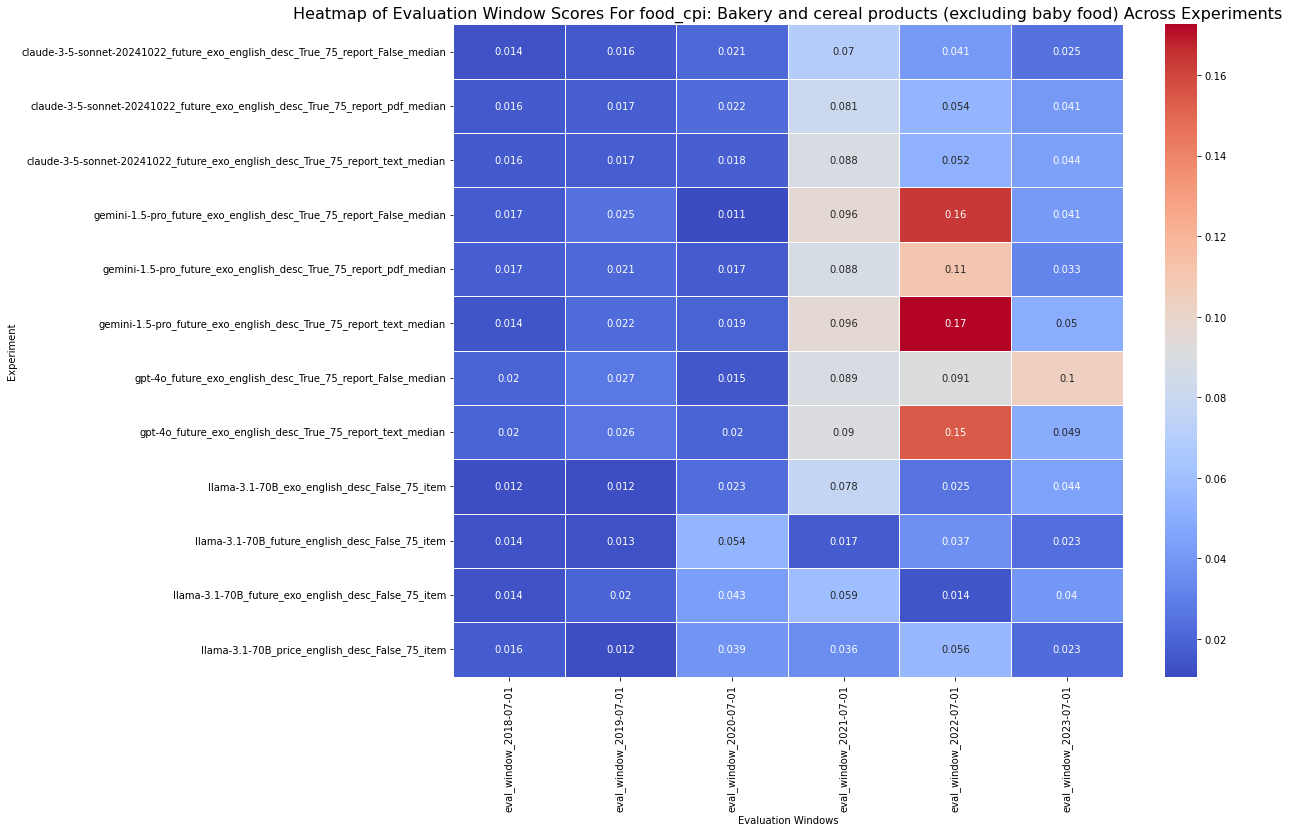

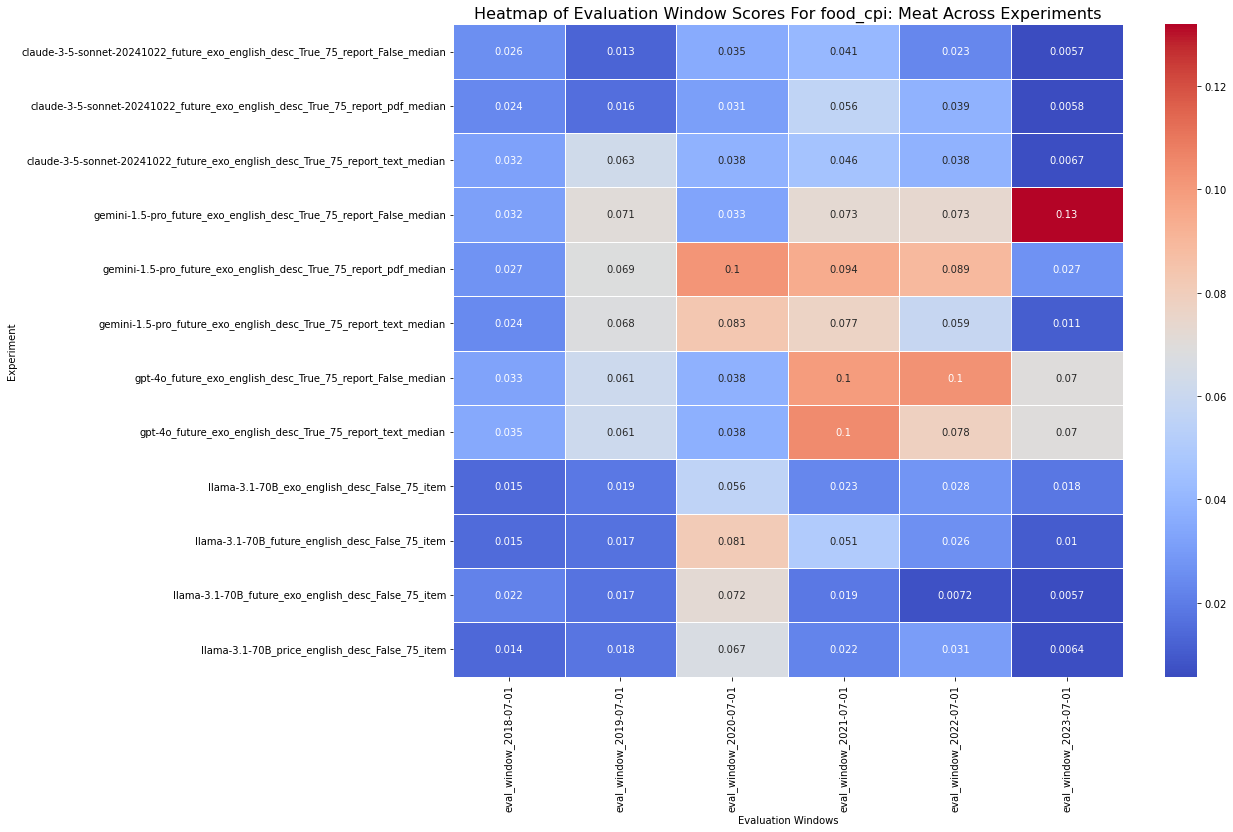

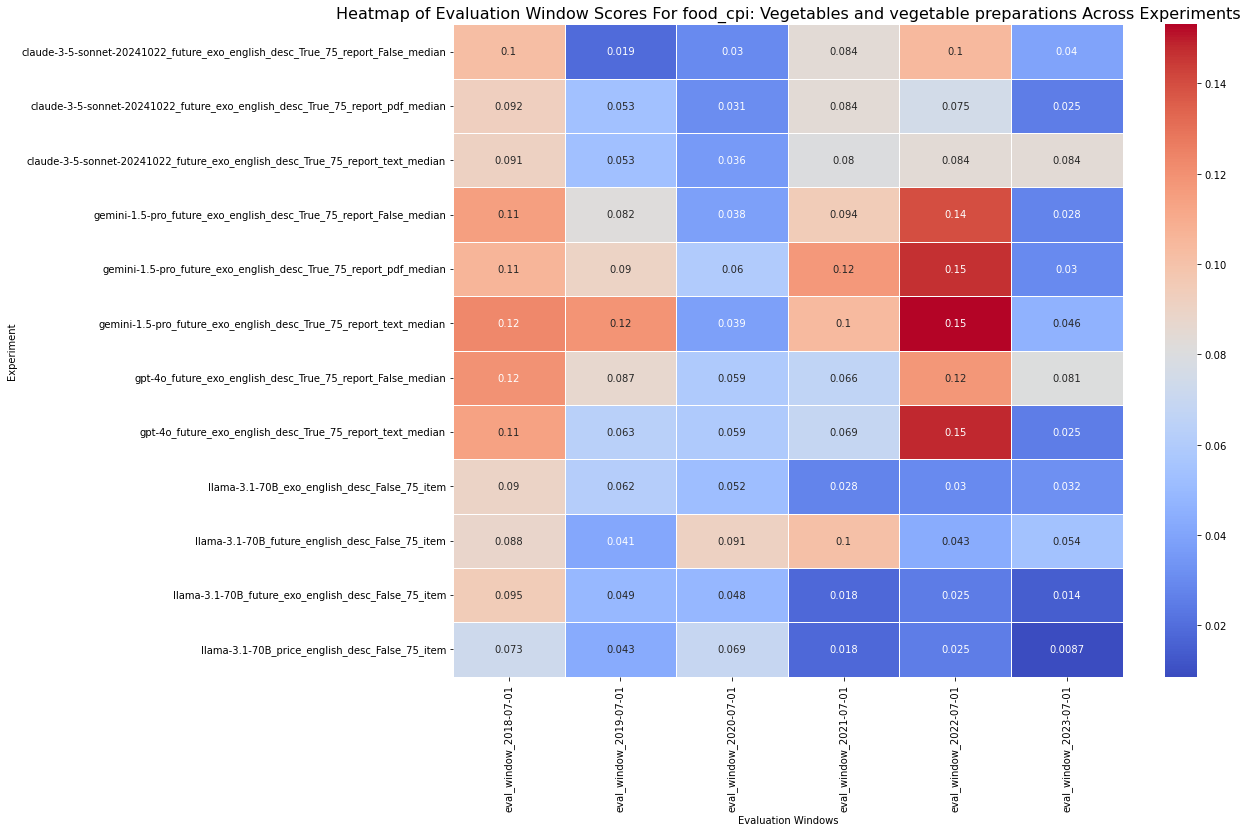

In [19]:
for category in target_categories:
    if 'restaurant' in category:
        continue
    df_filt = expanded_df.sort_values('experiment').loc[expanded_df['category']==category]
    plot_category(df_filt, category)

In [20]:
category

'food_cpi: Vegetables and vegetable preparations'

In [67]:
category

'food_cpi: Vegetables and vegetable preparations'

In [68]:
df_filt = expanded_df.loc[expanded_df['category']==target_categories[0]]
df_filt

,experiment,category,path,scores,mean,eval_window_2018-07-01,eval_window_2019-07-01,eval_window_2020-07-01,eval_window_2021-07-01,eval_window_2022-07-01,eval_window_2023-07-01
0,claude-3-5-sonnet-20240620_report_False,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.019770663026175018, 0.009294103079105985, 0...",0.027690,0.019771,0.009294,0.027295,0.060714,0.024075,0.024988
1,claude-3-5-sonnet-20240620_report_True,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.019770663026175018, 0.009294103079105985, 0...",0.029883,0.019771,0.009294,0.022251,0.053543,0.053130,0.021307
2,gpt-4o_report_True,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.008289007185541741, 0.010687187772188262, 0...",0.032349,0.008289,0.010687,0.031055,0.067934,0.046033,0.030098
3,ag_local_AutoETSModel,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.014882080042264502, 0.008929066042039024, 0...",0.033190,0.014882,0.008929,0.011434,0.084810,0.063616,0.015468
4,gpt-4o_report_False,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.007227672274065404, 0.011757098041449808, 0...",0.034011,0.007228,0.011757,0.024366,0.065702,0.070028,0.024988
5,gemini-1.5-pro_report_False,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.008456593699308198, 0.01629206489434754, 0....",0.034633,0.008457,0.016292,0.050232,0.058142,0.062390,0.012285
6,ag_global_all_SimpleFeedForwardModel_exp5_geop...,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.00801610596544404, 0.0145599506050403, 0.03...",0.035196,0.008016,0.014560,0.030113,0.077953,0.064910,0.015622
7,ag_global_all_ChronosModel,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.02530972245710051, 0.01239156869912828, 0.0...",0.035216,0.025310,0.012392,0.015510,0.085906,0.032863,0.039318
8,ag_local_NaiveModel,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.02053964284586431, 0.009613206214303307, 0....",0.035449,0.020540,0.009613,0.012701,0.086967,0.075196,0.007674
9,gemini-1.5-pro_report_True,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.019525289018950318, 0.010270364761014037, 0...",0.035689,0.019525,0.010270,0.029227,0.065191,0.075238,0.014680


In [69]:
expanded_df.sort_values('experiment')

,experiment,category,path,scores,mean,eval_window_2018-07-01,eval_window_2019-07-01,eval_window_2020-07-01,eval_window_2021-07-01,eval_window_2022-07-01,eval_window_2023-07-01
92,ag_global_all_ChronosModel,food_cpi: Other food products and non-alcoholi...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.006474179547532137, 0.011967665174608321, 0...",0.028094,0.006474,0.011968,0.019093,0.074737,0.048669,0.007626
118,ag_global_all_ChronosModel,food_cpi: Vegetables and vegetable preparations,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.08509518030440204, 0.022366525941475715, 0....",0.051723,0.085095,0.022367,0.050020,0.077947,0.060473,0.014440
45,ag_global_all_ChronosModel,food_cpi: Food,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.01566026277064578, 0.00343441804358874, 0.0...",0.020411,0.015660,0.003434,0.011589,0.061152,0.027770,0.002861
44,ag_global_all_ChronosModel,"food_cpi: Fish, seafood and other marine products",f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.015452188068932803, 0.014138629739339893, 0...",0.023334,0.015452,0.014139,0.015440,0.058698,0.015506,0.020771
17,ag_global_all_ChronosModel,food_cpi: Dairy products and eggs,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.024635868320352056, 0.010438862035784969, 0...",0.022044,0.024636,0.010439,0.012979,0.040806,0.019272,0.024132
...,...,...,...,...,...,...,...,...,...,...,...
9,gemini-1.5-pro_report_True,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.019525289018950318, 0.010270364761014037, 0...",0.035689,0.019525,0.010270,0.029227,0.065191,0.075238,0.014680
89,gemini-1.5-pro_report_True,food_cpi: Meat,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.011861230131251385, 0.03494158649245455, 0....",0.028788,0.011861,0.034942,0.034721,0.025577,0.045142,0.020486
4,gpt-4o_report_False,food_cpi: Bakery and cereal products (excludin...,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.007227672274065404, 0.011757098041449808, 0...",0.034011,0.007228,0.011757,0.024366,0.065702,0.070028,0.024988
85,gpt-4o_report_True,food_cpi: Meat,f'./output/{exp_test_description}/{EXPERIMENT_...,"[0.013865522560752061, 0.026228737061020285, 0...",0.025717,0.013866,0.026229,0.044078,0.033746,0.030200,0.006182


In [70]:
best_results_year_df.loc[best_results_year_df['category']==target_categories[8]].sort_values(by=['mean_score'])[['category', 'top_experiment', 'mean_score']]


#Bakery = 0, Meat = 6, Veg = 8, 

,category,top_experiment,mean_score
105,food_cpi: Vegetables and vegetable preparations,ag_local_PatchTSTModel,0.039089
106,food_cpi: Vegetables and vegetable preparations,ag_global_cpi_with_covariates_TemporalFusionTr...,0.040636
107,food_cpi: Vegetables and vegetable preparations,ag_global_cpi_with_covariates_TemporalFusionTr...,0.040842
108,food_cpi: Vegetables and vegetable preparations,ag_global_all_DeepARModel,0.043575
109,food_cpi: Vegetables and vegetable preparations,ag_local_SimpleFeedForwardModel,0.045348
110,food_cpi: Vegetables and vegetable preparations,ag_global_all_TemporalFusionTransformerModel_e...,0.045715
111,food_cpi: Vegetables and vegetable preparations,ag_global_cpi_with_covariates_TemporalFusionTr...,0.046689
112,food_cpi: Vegetables and vegetable preparations,ag_global_cpi_with_covariates_TemporalFusionTr...,0.047740
113,food_cpi: Vegetables and vegetable preparations,ag_local_DeepARModel,0.049516
114,food_cpi: Vegetables and vegetable preparations,ag_local_DLinearModel,0.050081
